# Modeling of Naive Bayes Classifier for Amazon Food Review

In [168]:
#Importing all the necessary libraries
import pandas as pd
import numpy as np
import sqlite3 as sq
import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import TimeSeriesSplit , train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import pickle
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from imblearn import over_sampling
from tabulate import tabulate as tab
import warnings
warnings.filterwarnings("ignore")

In [169]:
# Establishing a connection with amazon review database in sqlite format.
connection = sq.connect("database.sqlite")

In [170]:
# Reading the database file using pandas read sql query in AmazonReviewData variable.
AmazonReview = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""" , connection)

In [171]:
AmazonReview.shape

(525814, 10)

In [172]:
AmazonReview.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


* Replacing the score of the review with positive (score > 3) and negative (score < 3).

In [173]:
def Score(num):
    if num < 3:
        return 'negative'
    else:
        return 'positive'
    

In [174]:
score = []

for x in range (len(AmazonReview)):
    num = Score(AmazonReview['Score'][x])
    score.append(num)
AmazonReview['Score'] = score

In [175]:
AmazonReview.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Observations:

The dataset has 525814 reviews and 10 features.  
The amazon review dataset provides the following data:  
1) Id - review ID  
2) ProductID - unique Id for a given product  
3) UserID - Unique Id for the user  
4) ProfileName - Profile name of the user  
5) HelpfulnessNumerator - number of user who found the review heplful  
6) HelpfulnessDenominator - total number of users who found the review to be helpful or not.  
7) Score - product rating between 1 to 5 ( 3 been neutral, 1 & 2 been negative and 4 & 5 been positive)  
8) Time - timestamp of the review  
9) Summary - brief sumary of the review  
10) Text - text of the review  

Objective is to determine whether a given review is positive or negative using K-NN classifier.  
To do this, we replace the score column of amazon review as positive or negative by replacing all the values in score column below 3 as negative and above 3 as positive. All the reviews with score 3 are omitted, since they are neutral reviews (Neutral reviews donot help us in determining whether a given review is positive or negative).

In [176]:
# Removing all the duplicate data from the review.
AmazonReviewDataFiltered = AmazonReview.drop_duplicates(subset = {"UserId","Time","Text"}, keep = "first", inplace = False)
AmazonReviewDataFiltered.shape

(364133, 10)

# There were  161681 duplicate reviews.

In [177]:
AmazonReviewDataFiltered[AmazonReviewDataFiltered.HelpfulnessNumerator > AmazonReviewDataFiltered.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


Since HelpfulnessNumerator indicates that the review was helpful for the user and HelpfulnessDenominator indicates the whether the review has helped or not the user, therefore it is clear that helpfulnessNumerator will always be less than HelpfulnessDenominator. In all the reviews where helpfulnessNumerator is greater than HelpfulnessDenominator indicates its a false entry and therefore should be neglected. There are two such reviews as shown above 

In [178]:
#Program to remove those reviews where helpfulnessNumerator is greater than helpfulnessDenominator.
AmazonReviewDataFiltered = AmazonReviewDataFiltered[AmazonReviewDataFiltered.HelpfulnessNumerator <= AmazonReviewDataFiltered.HelpfulnessDenominator]
AmazonReviewDataFiltered.shape

(364131, 10)

## Text Preprocessing

In [179]:
def HtmlTagREmover(sentence):
    """Function to remove all the HTML tags in a given sentence using Regular Expressions"""
    tagPattern = re.compile('<*.?>')
    textClean = re.sub(tagPattern,r'', sentence)
    return textClean

In [13]:
def PuncRemover(sentence):
    """Function to remove all the Punctuation marks in a given sentence using regular expressions"""
    punPattern = re.sub(r'[? | ! | \ | \' | " | # | . | , | : | ( | ) | / | ]', r'', sentence)
    return punPattern

In [14]:
stopWordRequired = {'not'}
snoBallStemmer = SnowballStemmer ('english')# initialising the snowball stemmer
stopWordsEnglish = set(stopwords.words('english', )) - stopWordRequired #set of all the stopwords in english except 'not'.

In [180]:
# Program to remove stopwords, punctuations, special characters and stemming each words. 
i = 0
positivewords = [] # list to store all the positive words in a review text.
negativewords = [] # list to store all the negative words in a review text.
filteredSentence = [] # list to store all the filtered review text.
for sentn in AmazonReviewDataFiltered['Text'].values:
    filteredSent = []
    sentn = HtmlTagREmover(sentn)
    for word in sentn.split():
        for cleanedWord in PuncRemover(word).split():
            if (cleanedWord.isalpha() & (len(cleanedWord) > 2)):
                if (cleanedWord.lower() not in stopWordsEnglish):
                    stemmerWord = snoBallStemmer.stem(cleanedWord.lower())
                    filteredSent.append(stemmerWord)
                    if (AmazonReviewDataFiltered['Score'].values)[i] == 'positive':
                        positivewords.append(stemmerWord)
                    else:
                        negativewords.append(stemmerWord)
                else:
                    continue
            else:
                continue
    i += 1
    string1 =" ".join(filteredSent)
    filteredSentence.append(string1)
            

In [210]:
AmazonReviewDataFiltered['Text'] = filteredSentence# Replacing the original text of amazon review datatset with the filtered one.
AmazonReviewData['Text'].head()

In [24]:
AmazonReviewDataFiltered['Score'].value_counts()

positive    307026
negative     57105
Name: Score, dtype: int64

# Observation:
**There are 307026 positive reviews and 57105 negative reviews out of 364131 total reviews. Hence we have 84.3 % of positive reviews and 15.7% negative reviews  **

** It also tells us that the amazon review dataset has an imbalanced dataset.**

In [25]:
#Program to form a sentence using all the positive words from the review text.
positivesent = ''
for word in positivewords:
    positivesent += ' ' + word

In [26]:
#Program to form a sentence using all the negative words from the review text.
negativesent = ''
for word in negativewords:
    negativesent += ' ' + word

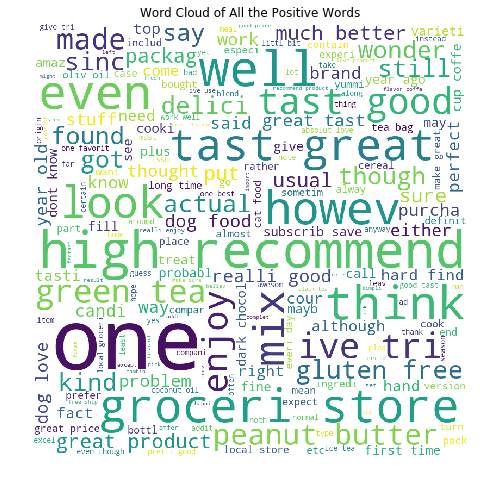

In [30]:
print('Sentence with all positive words in the reviews :\n')
print(positivesent[:25])
print('\n')
print('Sentence with all negative words in the reviews :\n')
print(negativesent[:25])

#Program to form a word cloud of all the positive in the review text.
wordcloud_positive_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(positivesent) 

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_positive_words)
plt.title("Word Cloud of All the Positive Words")
plt.axis('off')
plt.show()


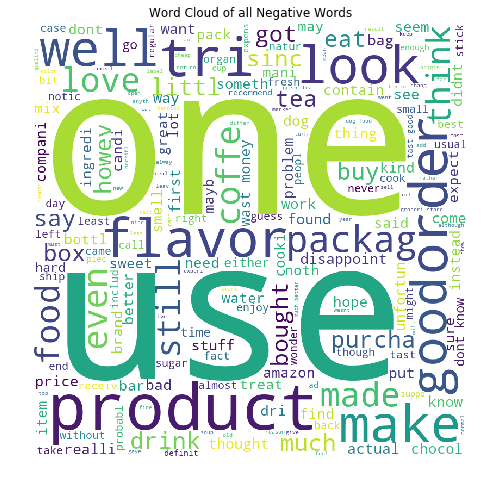

In [70]:
#Program to form a word cloud of all the positive in the review text.
wordcloud_negative_words = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(negativesent) 

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_negative_words)
plt.title("Word Cloud of all Negative Words")
plt.axis('off')
plt.show()

In [32]:
# Sampling 100k data points from AmazonREviewDataFiltered to perform BoW, TF - IDF, word2vec and TF - IDF avgerage w2v, to reduce processing time.
AmazonPositiveReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 'positive'].sample(n =84300) # Sampling 84300 positive data points from AmazonReviewDataFiltered, i.e. 84.3%
AmazonNegativeReviewData = AmazonReviewDataFiltered[AmazonReviewDataFiltered['Score'] == 'negative'].sample(n = 15700) # Sampling 15700 negative data points from AmazonReviewDataFiltered, i.e. 15.7%
3AmazonReviewDataSampled = AmazonPositiveReviewData.append(AmazonNegativeReviewData, ignore_index= True) # Appending the samples of positive and negative data points to form AmazonReviewDataSampled 

In [53]:
# Extablishing connection and storing the filtered amazon data set in AmazonReviewDataSampled.sqlite database
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled.to_sql('Reviews', conn,if_exists= 'replace' )

In [119]:
conn = sq.connect('AmazonReviewDataSampled.sqlite')
AmazonReviewDataSampled = pd.read_sql_query("""SELECT * FROM Reviews """, conn)

In [120]:
#AmazonReviewDataSampled = AmazonReviewDataSampled.drop('level_0', axis = 1)
AmazonReviewDataSampled.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,positive,1234137600,Excellent taste and quality,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,positive,1285718400,Limited Variety,candi good childhood favorit mani get bag piec...
2,2,323478,B000LNWIVU,A12Y0FZ2EZUU2K,"Jill E. Trainor ""Jillylam""",6,7,positive,1179100800,Victor Fly Bag is Great!,purchas item put near chicken coop first thoug...
3,3,436119,B001I8DP5U,A2LXIOHTEYTFUW,"Hyena ""The world is upheld by the veracity of...",0,0,positive,1310169600,GOOD COFFEE,excel cup favorit regular folger not like cost...
4,4,259662,B0032AM8HS,A13NB7KO0EQ24J,"J. Rosenberg ""Jenrose""",1,1,positive,1308528000,One of the best tools in my tool chest for dea...,tea tasti import knock back queasi start first...


** Replacing Positive and Negative Scores with Binary 1 and 0. **

In [121]:
def binaryScore(num):
    if num != 'positive':
        return 0
    else:
        return 1

In [122]:
binary = []

for x in range (len(AmazonReviewDataSampled)):
    num = binaryScore(AmazonReviewDataSampled['Score'][x])
    binary.append(num)
AmazonReviewDataSampled['Score'] = binary
    

In [123]:
AmazonReviewDataSampled.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,1,1234137600,Excellent taste and quality,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,1,1285718400,Limited Variety,candi good childhood favorit mani get bag piec...
2,2,323478,B000LNWIVU,A12Y0FZ2EZUU2K,"Jill E. Trainor ""Jillylam""",6,7,1,1179100800,Victor Fly Bag is Great!,purchas item put near chicken coop first thoug...
3,3,436119,B001I8DP5U,A2LXIOHTEYTFUW,"Hyena ""The world is upheld by the veracity of...",0,0,1,1310169600,GOOD COFFEE,excel cup favorit regular folger not like cost...
4,4,259662,B0032AM8HS,A13NB7KO0EQ24J,"J. Rosenberg ""Jenrose""",1,1,1,1308528000,One of the best tools in my tool chest for dea...,tea tasti import knock back queasi start first...


In [124]:
# Program to split the positive and negative reviews of the amazon dataset based on time.
AmazonReviewDataSampledPositive = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 1]

AmazonReviewDataSampledNegative = AmazonReviewDataSampled[AmazonReviewDataSampled['Score'] == 0]
# Program to sort the positive and negative review dataset with respect to time.
AmazonReviewDataSampledPositive.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True )
AmazonReviewDataSampledNegative.sort_values(by = ['Time'],axis = 0,ascending= True, inplace= True)

In [125]:
AmazonReviewDataSampledPositive.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44503,44503,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...
76271,76271,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,one movi movi collect fill comedi action whate...
14486,14486,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,get crazyim look beatlejuic french version vid...
49280,49280,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,realli good idea final product outstand use de...


In [91]:
AmazonReviewDataSampledNegative.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
89700,89700,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,0,992217600,CASPER IS THE GHOST WITH THE MOST,michael keaton bring distinguish characterist ...
93897,93897,230327,B00004RYGX,A3M5O6UHXO9IBU,Gary,2,34,0,1052265600,Certificate: Puerile,embarrass comedi come like child attent defici...
94769,94769,225941,B000PKFZH8,A375QRG43POEW6,dndnd,23,25,0,1069977600,Stay Away...,product ship great packag look good tast horri...
93593,93593,342462,B000084F3O,A3DWUM6SN3N3NR,"Author Brian Wallace (Mind Transmission, Inc.)",4,33,0,1076457600,the most unnatural odor,realli hate fan van patten year feel must save...


In [95]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset.
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

In [96]:
AmazonReviewDataSampledTrain.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44503,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...
1,76271,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,one movi movi collect fill comedi action whate...
2,14486,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,get crazyim look beatlejuic french version vid...
3,49280,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,realli good idea final product outstand use de...
4,64330,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,sick scad nasti toothpick counter tint concept...


In [97]:
AmazonReviewDataSampledTest.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,37662,192950,B000OV08FC,A3DMVZ9D6XSS1E,Hannah,0,0,1,1328572800,Good coffee,easi quick make heat water empti sachet lot le...
1,84246,107310,B005DFL4PM,AOTUPV596EAHL,Callie14,0,0,1,1328572800,OMG... like Reeses,bought most put protein shake without calori l...
2,23050,420167,B005NVU5BK,A2J19U8H5SSFCJ,Linda Dalton,0,0,1,1328572800,Excellent chocolate,never heard brand amazon offer special promot ...
3,27788,120546,B005K4Q37A,AYWXEYT90R54K,Jennifer Komarek,0,0,1,1328572800,Love it!,not big coffe drinker drink coffe use lot crea...
4,38612,56323,B0039ZOZ86,A24EDLRX54TE36,"Gretchen Fehling ""tawonda""",1,1,1,1328572800,great snack for dieters!@,great dieter calori per pack great throw lucnc...


In [27]:
AmazonReviewDataSampledTrain['Score'].value_counts()

positive    59010
negative    10990
Name: Score, dtype: int64

# Observation: The train dataset has 59k positive reviews and 10k negative reviews. Hence the train dataset is imbalanced. The total reviews in the train dataset is 70k.

In [14]:
AmazonReviewDataSampledTest['Score'].value_counts()

positive    25290
negative     4710
Name: Score, dtype: int64

# Observation: The test dataset has 25k positive reviews and 4.7k negative reviews. Total reviews in test dataset is 30k

# Vectorizing the Text column of the Dataset

# 1) Bag of Words

In [24]:
# Initialising and obtaining the bag of words of the Train Dataset.
bagOfWordsVec = CountVectorizer()
bowTrain = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'])
bowTrain

<70000x42841 sparse matrix of type '<class 'numpy.int64'>'
	with 2195461 stored elements in Compressed Sparse Row format>

# Observation : BOW for training dataset is a sparse matrix with 42.8k dimensions.

In [25]:
# Initialising and obtaining the bag of words of the Test Dataset
bowTest = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'])
bowTest

<30000x42841 sparse matrix of type '<class 'numpy.int64'>'
	with 935696 stored elements in Compressed Sparse Row format>

# Observation : BOW for test dataset is a sparse matrix with 42.8k dimensions.

#  2) TF - IDF

In [105]:
#Inilialzing and obtaining the TF-IDF of the Train Dataset.
tfidfVec = TfidfVectorizer(ngram_range=(1,2))
tfidfVecTrain = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'])

In [106]:
features = tfidfVec.get_feature_names()# to get the features of tfidf vector.
tfidfVecTrain

<70000x994451 sparse matrix of type '<class 'numpy.float64'>'
	with 4738319 stored elements in Compressed Sparse Row format>

# Observation : TFIDF for test dataset is a sparse matrix with 99.4k dimensions.

In [107]:
#obtaining the TF-IDF of the Test Dataset.
tfidfVecTest = tfidfVec.transform(AmazonReviewDataSampledTest['Text'])
tfidfVecTest

<30000x994451 sparse matrix of type '<class 'numpy.float64'>'
	with 1732295 stored elements in Compressed Sparse Row format>

# Observation : TFIDF for test dataset is a sparse matrix with 99.4k dimensions.

# Naive Bayes Classifier for the Amazon Food Review Dataset.

** We observe that the Amazon food review datatset is an imbalance dataset, with positive reviews making around 85% of the total reviews.**  

** We have the train dataset which has 59010 positive and 10990 negative reviews, while the test dataset has 25290 positive reviews and 4710 negative review. ** 

** We will model the Naive Bayes classifier with 10 fold cross validation to find the optimal value of alpha which is the hyperparameter of the naive bayes classifier .  **  

** Since the dataset is imbalanced, AUC is used to evaluate the performance of the model. A perfect classifier would have a AUC more than 0.5 with 1 been the best and 0 been the worse. **

** There are three types of Naive Bayes classifiers : **
** 1) Bernoulli Naive Bayes: widely used if the features have gaussian distrubution. **  
** 2) Multinomial Naive Bayes: widely used for text classification.**  
** 3) Complement Naive Bayes: widely used for text classification and if the dataset is imbalanced. **

** Since we are doing text classification, we will study naive bayes classifier using multinomial and complement naive bayes. We will try to see which one performs better for our dataset.**



# Obejective :  To determine whether a given Review is a positive review or not.

In [182]:
#Program to determine the optimal value of alpha for Naive Bayes classifier using Multinomial and Complement Naive Bayes
def Classifier(clf, X_features, Y_classlabel):
    """Function to determine the best value of aplha using ComplementNB and MultinomialNB. note: clf should be either Complement_Naive_Bayes for ComplementNB and Multinomial_Naive_Bayes for MultinomialNB"""
    cv_scores = [] # Varianle to store the cross validation scores.
    value = [0.0001,0.001,0.01,0.1,0,1,10,50,100] # list containing different values of alpha.
    print('Alpha Value \t AUC')
   
    if clf =='Complement_Naive_Bayes':
        #Program to perform Complement naive bayes
        for x in value:
            classifier = ComplementNB(alpha = x) # initializing the classifier
            scores = cross_val_score(classifier, X_features,Y_classlabel,n_jobs = 4, cv = 10, scoring = 'roc_auc') # obtaining the cross validation scores for 10 fold cross validation
            cv_scores.append(scores.mean())
            print('%r \t\t %.3f '%(x,scores.mean()))
    else:
        #Program to perform multinomial naive bayes
        for x in value:
            classifier = MultinomialNB(alpha = x) # initializing the classifier 
            scores = cross_val_score(classifier, X_features,Y_classlabel,n_jobs = 4, cv = 10, scoring = 'roc_auc')# obtaining the cross validation scores for 10 fold cross validation
            cv_scores.append(scores.mean())
            print('%r \t\t %.3f '%(x,scores.mean()))
    # Program to plot the alpha v/s cv_scores
    plt.figure(figsize= (10,10))
    plt.plot(value, cv_scores)
    plt.xlim(-1, 100)


    for xy in zip(value, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Plot of alpha v/s %r " %clf)
    plt.xlabel('alpha value')
    plt.ylabel('AUC')
    plt.show()

In [184]:
# Program to determine the accuracy of the Naive Bayes classifier using the test dataset

def NaiveBayesClassifeir(clf, X_train,Y_Train,X_Test,Y_Test,optimalAlpha):
    """Function to determine the best value of aplha using ComplementNB and MultinomialNB. note: clf should be either Complement_Naive_Bayes for ComplementNB and Multinomial_Naive_Bayes for MultinomialNB"""
    if clf =='Complement_Naive_Bayes':
        #Program to perform Complement naive bayes
        clfnb = ComplementNB(alpha = optimalAlpha)#initializing the classifier
        clfnb.fit(X_train,Y_Train) # fitting the model
        predict = clfnb.predict(X_Test) # predicting the class label of the test dataset
        auc = roc_auc_score(Y_Test,predict) # calculating the AUC
        confusionMatrix = confusion_matrix(Y_Test,predict) # obtaining the confusion matrix
        TPR = (confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])) * 100 # calculating the TPR 
        TNR = (confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])) * 100 # calculating the TNR
        print('Optimal Alpha \tAUC \t\tTPR \t\tTNR')
        print('%r \t\t%.3f \t\t%.3f \t\t%.3f'%(optimalAlpha,auc,TPR,TNR))
        
    else:
        #Program to perform multinomial naive bayes
        #Program to perform Complement naive bayes
        clfnb = MultinomialNB(alpha = optimalAlpha)#initializing the classifier
        clfnb.fit(X_train,Y_Train) # fitting the model
        predict = clfnb.predict(X_Test) # predicting the class label of the test dataset
        auc = roc_auc_score(Y_Test,predict) # calculating the AUC
        confusionMatrix = confusion_matrix(Y_Test,predict) # obtaining the confusion matrix
        TPR = (confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])) * 100 # calculating the TPR 
        TNR = (confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])) * 100 # calculating the TNR
        print('Optimal Alpha \tAUC \t\tTPR \t\tTNR')
        print('%r \t\t%.3f \t\t%.3f \t\t%.3f'%(optimalAlpha,auc,TPR,TNR))

# Program to Train and Test the Naive Bayes Classifier using Bag Of Words Vectorizer

Alpha Value 	 AUC
0.0001 		 0.840 
0.001 		 0.861 
0.01 		 0.884 
0.1 		 0.902 
0 		 0.773 
1 		 0.900 
10 		 0.721 
50 		 0.578 
100 		 0.555 


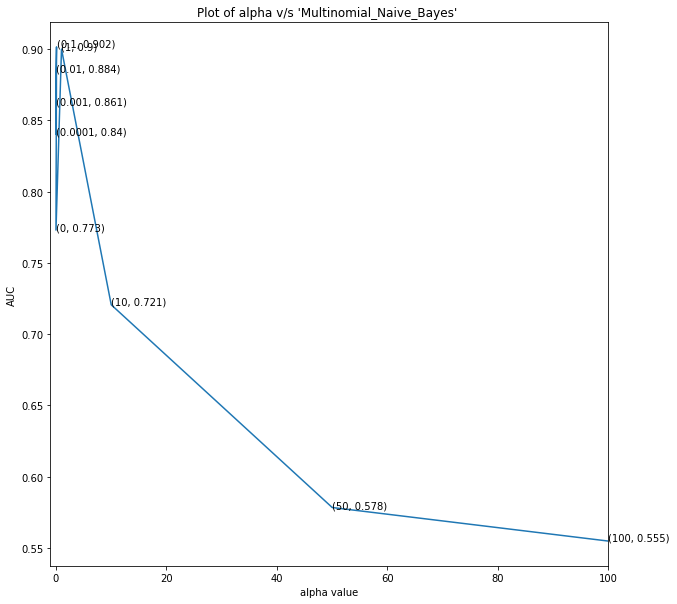

In [183]:
Classifier('Multinomial_Naive_Bayes', bowTrain, AmazonReviewDataSampledTrain['Score'])

** Optimal Value of Alpha is 0.1 **

In [185]:

NaiveBayesClassifeir('Multinomial_Naive_Bayes',bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'], 0.1)

Optimal Alpha 	AUC 		TPR 		TNR
0.1 		0.821 		93.578 		70.701


Alpha Value 	 AUC
0.0001 		 0.840 
0.001 		 0.861 
0.01 		 0.884 
0.1 		 0.902 
0 		 0.773 
1 		 0.900 
10 		 0.721 
50 		 0.579 
100 		 0.556 


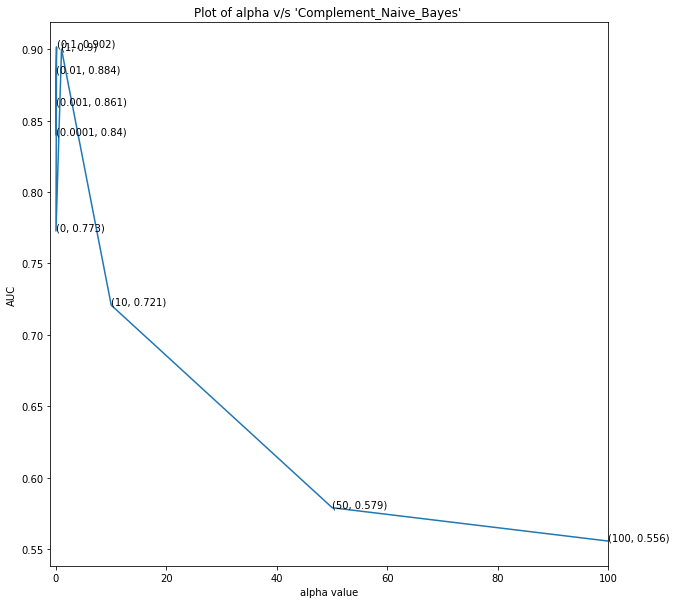

In [191]:
Classifier('Complement_Naive_Bayes', bowTrain, AmazonReviewDataSampledTrain['Score'])

# Optimal Value of alpha is 0.1

In [186]:

NaiveBayesClassifeir('Complement_Naive_Bayes',bowTrain,AmazonReviewDataSampledTrain['Score'],bowTest,AmazonReviewDataSampledTest['Score'], 0.1)

Optimal Alpha 	AUC 		TPR 		TNR
0.1 		0.846 		87.849 		81.295


# Program to Train and Test the Naive Bayes Classifier using TFIDF Vectorizer

Alpha Value 	 AUC
0.0001 		 0.873 
0.001 		 0.894 
0.01 		 0.904 
0.1 		 0.909 
0 		 0.793 
1 		 0.814 
10 		 0.717 
50 		 0.678 
100 		 0.666 


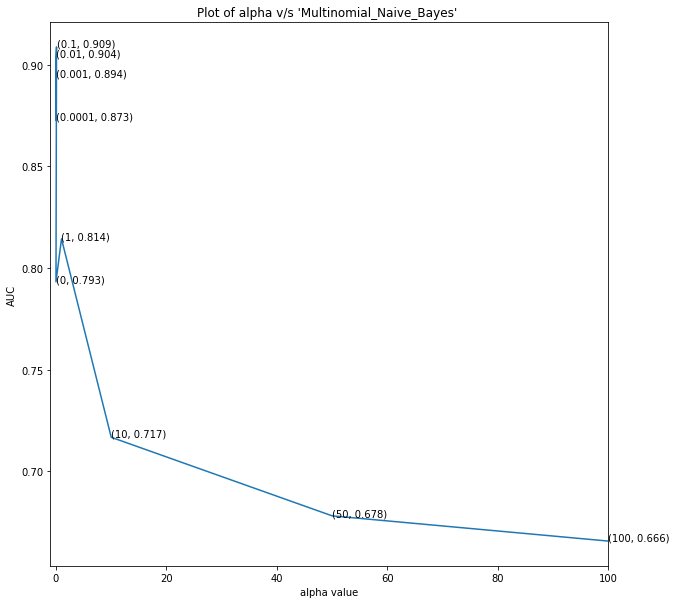

In [187]:
Classifier('Multinomial_Naive_Bayes', tfidfVecTrain, AmazonReviewDataSampledTrain['Score'])

# Optimal value of Alpha is 0.1

In [188]:

NaiveBayesClassifeir('Multinomial_Naive_Bayes',tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],tfidfVecTest,AmazonReviewDataSampledTest['Score'], 0.1)

Optimal Alpha 	AUC 		TPR 		TNR
0.1 		0.565 		99.905 		13.036


Alpha Value 	 AUC
0.0001 		 0.873 
0.001 		 0.894 
0.01 		 0.904 
0.1 		 0.909 
0 		 0.794 
1 		 0.814 
10 		 0.717 
50 		 0.678 
100 		 0.666 


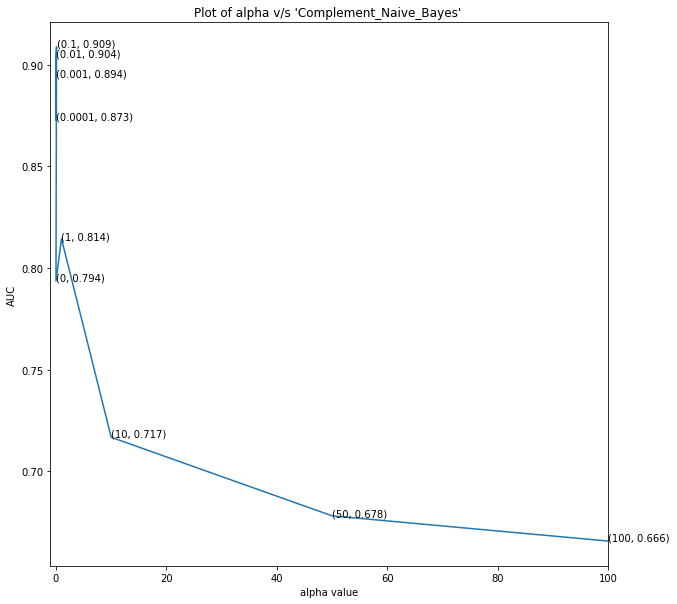

In [189]:
Classifier('Complement_Naive_Bayes', tfidfVecTrain, AmazonReviewDataSampledTrain['Score'])

# Optimal value of alpha is 0.1

In [190]:

NaiveBayesClassifeir('Complement_Naive_Bayes',tfidfVecTrain,AmazonReviewDataSampledTrain['Score'],tfidfVecTest,AmazonReviewDataSampledTest['Score'], 0.1)

Optimal Alpha 	AUC 		TPR 		TNR
0.1 		0.702 		99.134 		41.338


# Improving TNR by using the summary column of the dataset to predict whether the review is positive or not alongwith text column of the dataset.

In [128]:
# Program to remove stopwords, punctuations, special characters and stemming each words. 
i = 0
positivewords = [] # list to store all the positive words in a review text.
negativewords = [] # list to store all the negative words in a review text.
filteredSentence = [] # list to store all the filtered review text.
for sentn in AmazonReviewDataSampled['Summary'].values:
    filteredSent = []
    sentn = HtmlTagREmover(sentn)
    for word in sentn.split():
        for cleanedWord in PuncRemover(word).split():
            if (cleanedWord.isalpha() & (len(cleanedWord) > 2)):
                if (cleanedWord.lower() not in stopWordsEnglish):
                    stemmerWord = snoBallStemmer.stem(cleanedWord.lower())
                    filteredSent.append(stemmerWord)
                    if (AmazonReviewDataSampled['Score'].values)[i] == 'positive':
                        positivewords.append(stemmerWord)
                    else:
                        negativewords.append(stemmerWord)
                else:
                    continue
            else:
                continue
    i += 1
    string1 =" ".join(filteredSent)
    filteredSentence.append(string1)

AmazonReviewDataSampled['Summary'] = filteredSentence# Replacing the original text of amazon review datatset with the filtered one.
AmazonReviewDataSampled['Summary'].head()

In [137]:
AmazonReviewDataSampled

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,415646,B000EDDS6Q,A7WTII41IWQF,D. Miller,0,0,1,1234137600,excel tast qualiti,great cereal tast good provid good nutrit like...
1,1,473476,B002RBQW20,A3IJY44UJZL9YC,jamesyipoo,4,4,1,1285718400,limit varieti,candi good childhood favorit mani get bag piec...
2,2,323478,B000LNWIVU,A12Y0FZ2EZUU2K,"Jill E. Trainor ""Jillylam""",6,7,1,1179100800,victor fli bag great,purchas item put near chicken coop first thoug...
3,3,436119,B001I8DP5U,A2LXIOHTEYTFUW,"Hyena ""The world is upheld by the veracity of...",0,0,1,1310169600,good coff,excel cup favorit regular folger not like cost...
4,4,259662,B0032AM8HS,A13NB7KO0EQ24J,"J. Rosenberg ""Jenrose""",1,1,1,1308528000,one best tool tool chest deal morn sick,tea tasti import knock back queasi start first...
5,5,523939,B004JGQ15Y,A3HREGZ51J1Q9J,"Sharon Michaels ""SharonMichaels""",0,0,1,1307577600,treat,treat like eat candi peanut butter oreo cooki ...
6,6,53105,B003ZXHGOW,A3B2O118KZEFA9,Juli Pickvet,1,1,1,1322870400,great awesom snack,snack good take lunch work home look forward o...
7,7,34489,B008FHUDW0,A3BGYTGMNP05RE,Sarah Lilliendahl,1,1,1,1331510400,delici good price fast ship,ive love caribou coffe caribou blend ever sinc...
8,8,328697,B000LL0ZIK,A208341LN98FCH,Agnieszka Skrzypkowiak,2,2,1,1226102400,mmmm good till last drop,best ginger tea ive ever full flavor littl spi...
9,9,24536,B000VK2W6O,A3CJ12GJ9VQG6I,Cates,0,0,1,1349654400,belgian mal absolut love,soft small great train recommend break half pu...


In [138]:
# Performing Time Based Spliting of the positive and negative reviews to form 70% of train and 30% of test dataset based on time based splitting .
Positive_tr = AmazonReviewDataSampledPositive[0:59010]

Positive_ts = AmazonReviewDataSampledPositive[59010:]

Negative_tr = AmazonReviewDataSampledNegative[0:10990]
Negative_ts = AmazonReviewDataSampledNegative[10990:]

AmazonReviewDataSampledTrain = Positive_tr.append(Negative_tr, ignore_index = True)
AmazonReviewDataSampledTest = Positive_ts.append(Negative_ts, ignore_index = True)

# BOW vectorizer

** Obtaining the bow vectors using the text and summary columns of the dataset.**

In [139]:
bowTrain_TS = bagOfWordsVec.fit_transform(AmazonReviewDataSampledTrain['Text'] + AmazonReviewDataSampledTrain['Summary'])

In [140]:
bowTrain_TS

<70000x94040 sparse matrix of type '<class 'numpy.int64'>'
	with 2367041 stored elements in Compressed Sparse Row format>

In [141]:
bowTest_TS = bagOfWordsVec.transform(AmazonReviewDataSampledTest['Text'] + AmazonReviewDataSampledTest['Summary'])

In [142]:
bowTest_TS 

<30000x94040 sparse matrix of type '<class 'numpy.int64'>'
	with 990089 stored elements in Compressed Sparse Row format>

# TFIDF Vectorizer

** Obtaining the TFIDF vectors using the text and summary columns of the dataset. **

In [143]:
tfidfVecTrain_TS = tfidfVec.fit_transform(AmazonReviewDataSampledTrain['Text'] + AmazonReviewDataSampledTrain['Summary'])

In [144]:
tfidfVecTrain_TS

<70000x1208766 sparse matrix of type '<class 'numpy.float64'>'
	with 5113434 stored elements in Compressed Sparse Row format>

In [145]:
tfidfVecTest_TS = tfidfVec.transform(AmazonReviewDataSampledTest['Text'] + AmazonReviewDataSampledTest['Summary'])

In [146]:
tfidfVecTest_TS

<30000x1208766 sparse matrix of type '<class 'numpy.float64'>'
	with 1808101 stored elements in Compressed Sparse Row format>

# Program to Train and Test the Naive Bayes Classifier using BOW Vectorizer

Alpha Value 	 AUC
0.0001 		 0.876 
0.001 		 0.895 
0.01 		 0.914 
0.1 		 0.927 
0 		 0.811 
1 		 0.902 
10 		 0.649 
50 		 0.556 
100 		 0.543 


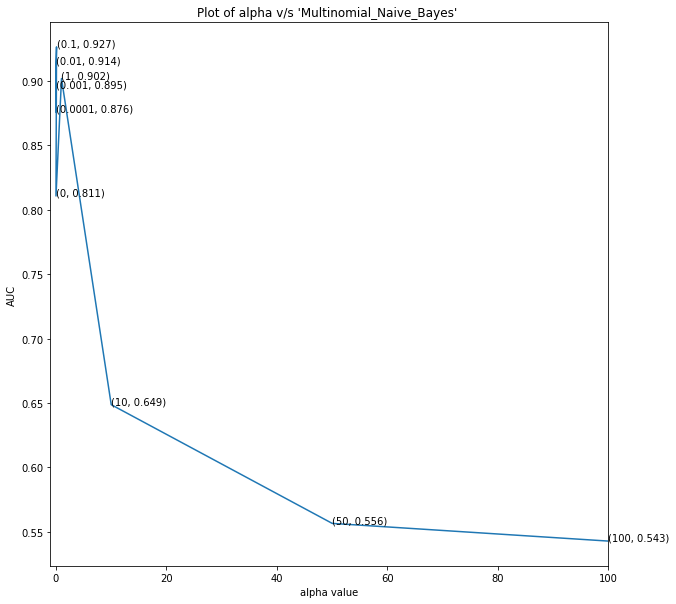

In [192]:
Classifier('Multinomial_Naive_Bayes', bowTrain_TS, AmazonReviewDataSampledTrain['Score'])

# Optimal value of alpha is 0.1

In [193]:

NaiveBayesClassifeir('Multinomial_Naive_Bayes',bowTrain_TS,AmazonReviewDataSampledTrain['Score'],bowTest_TS,AmazonReviewDataSampledTest['Score'], 0.1)

Optimal Alpha 	AUC 		TPR 		TNR
0.1 		0.842 		94.318 		74.161


Alpha Value 	 AUC
0.0001 		 0.876 
0.001 		 0.895 
0.01 		 0.914 
0.1 		 0.927 
0 		 0.810 
1 		 0.902 
10 		 0.650 
50 		 0.558 
100 		 0.544 


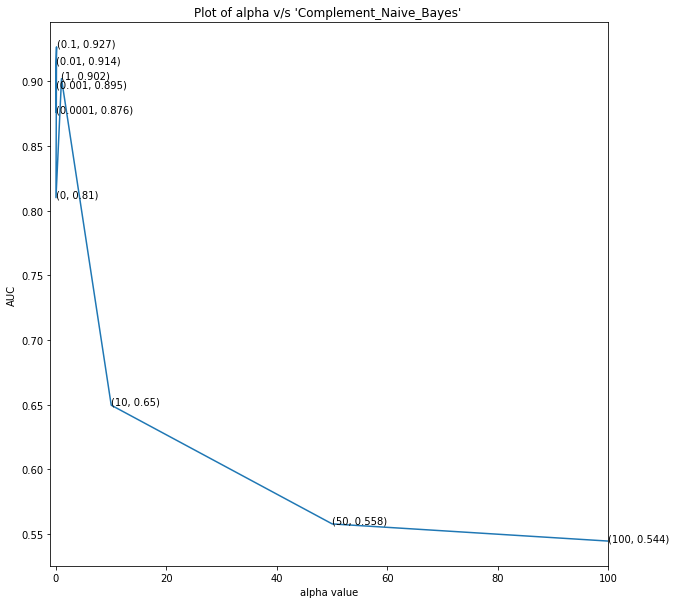

In [194]:
Classifier('Complement_Naive_Bayes', bowTrain_TS, AmazonReviewDataSampledTrain['Score'])

# Optimal value of alpha is 0.1

In [196]:

NaiveBayesClassifeir('Complement_Naive_Bayes',bowTrain_TS,AmazonReviewDataSampledTrain['Score'],bowTest_TS,AmazonReviewDataSampledTest['Score'], 0.1)

Optimal Alpha 	AUC 		TPR 		TNR
0.1 		0.873 		90.708 		83.822


# Program to Train and Test the Naive Bayes Classifier using TFIDF Vectorizer

Alpha Value 	 AUC
0.0001 		 0.899 
0.001 		 0.917 
0.01 		 0.925 
0.1 		 0.923 
0 		 0.831 
1 		 0.802 
10 		 0.699 
50 		 0.660 
100 		 0.649 


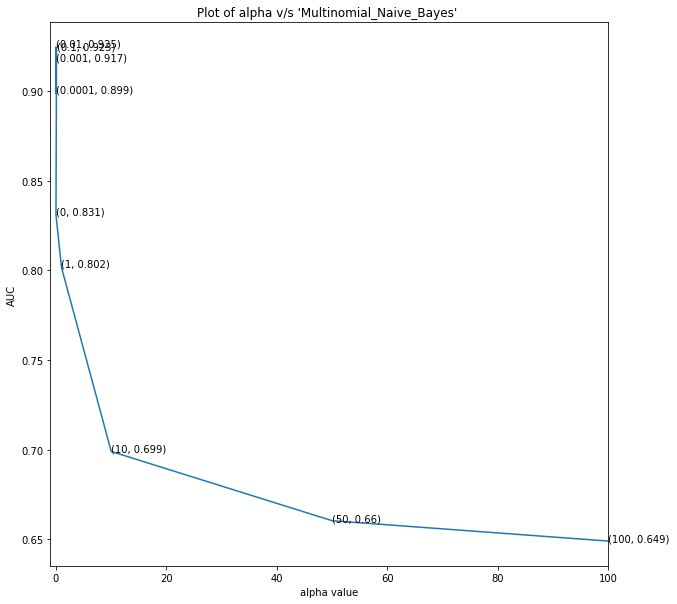

In [197]:
Classifier('Multinomial_Naive_Bayes',tfidfVecTrain_TS, AmazonReviewDataSampledTrain['Score'])

# Optimal value of alpha is 0.01

In [198]:

NaiveBayesClassifeir('Multinomial_Naive_Bayes',tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfVecTest_TS,AmazonReviewDataSampledTest['Score'], 0.01)

Optimal Alpha 	AUC 		TPR 		TNR
0.01 		0.712 		99.205 		43.121


Alpha Value 	 AUC
0.0001 		 0.899 
0.001 		 0.917 
0.01 		 0.925 
0.1 		 0.923 
0 		 0.831 
1 		 0.802 
10 		 0.699 
50 		 0.660 
100 		 0.649 


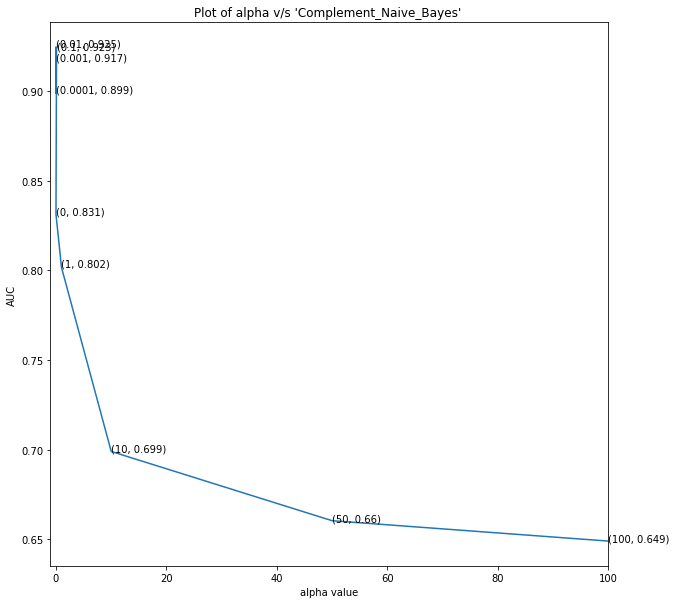

In [200]:
Classifier('Complement_Naive_Bayes',tfidfVecTrain_TS, AmazonReviewDataSampledTrain['Score'])

# Optimal value of Alpha is 0.01

In [201]:
NaiveBayesClassifeir('Complement_Naive_Bayes',tfidfVecTrain_TS,AmazonReviewDataSampledTrain['Score'],tfidfVecTest_TS,AmazonReviewDataSampledTest['Score'], 0.01)

Optimal Alpha 	AUC 		TPR 		TNR
0.01 		0.822 		96.580 		67.813


In [213]:
print('Table 2: Table showing the vectorizer, corresponding values of alpha and accuracy of the Naive Bayes classifeir trained using imbalanced Dataset\n')
table = [['BOW (using Text only) ','Multinomial Naive Bayes', 0.1,0.821,93.578,70.701],['BOW (using Text only)','Complement Naive Bayes', 0.1,0.846,87.849,81.245],['TFIDF (using Text only)','Multinomial Naive Bayes',0.1,0.565,99.905,13.036],['TFIDF (using Text only)','Complement Naive Bayes',0.1,0.702,99.134,41.338],['BOW (using Text+Summary)','Multinomial Naive Bayes', 0.1,0.842,94.318,74.161],['BOW (using Text+Summary)','Complement Naive Bayes', 0.1,0.873,90.708,83.822],['TFIDF (using Text+Summary)','Multinomial Naive Bayes',0.01,0.712,99.205,43.121],['TFIDF (using Text+Summary)','Complement Naive Bayes',0.01,0.822,96.58,67.813]]
headers = ['Vectorizer ', 'Type Of Naive Bayes Classifier', 'Optimal value of alpha', 'AUC', 'TPR','TNR']
print (tab(table, headers, numalign = 'center'))

Table 2: Table showing the vectorizer, corresponding values of alpha and accuracy of the Naive Bayes classifeir trained using imbalanced Dataset

Vectorizer                  Type Of Naive Bayes Classifier     Optimal value of alpha    AUC    TPR     TNR
--------------------------  --------------------------------  ------------------------  -----  ------  ------
BOW (using Text only)       Multinomial Naive Bayes                     0.1             0.821  93.578  70.701
BOW (using Text only)       Complement Naive Bayes                      0.1             0.846  87.849  81.245
TFIDF (using Text only)     Multinomial Naive Bayes                     0.1             0.565  99.905  13.036
TFIDF (using Text only)     Complement Naive Bayes                      0.1             0.702  99.134  41.338
BOW (using Text+Summary)    Multinomial Naive Bayes                     0.1             0.842  94.318  74.161
BOW (using Text+Summary)    Complement Naive Bayes                      0.1           

# Conclusion:
** From the above table we see that, Complement Naive bayes performs well as compared to multinomial naive bayes, its because complement naive bayes does not take into consideration the probability of the class label while multinomial naive does take into consideration the probability of the class label. Hence if the dataset is an imbalance dataset, multinomial naive bayes is more baised towards the majority class, thats what is evident in the above analysis. We also observe that, by including the summary of the dataset, it was possible to increase the True Negative rate. Bag of words performs better as compared to TFIDF using both multinomial or complement naive bayes. **

** Therefore, we can conclude that for text classification using naive bayes classifier, its better to prefer complement naive bayes if the dataset is imbalance. Also we can improve the performance of the model by using other features from the dataset, like in our case, the model performance improved when summary and text was used for classification.**

# END